In [1]:
import torch

In [2]:
# Configuración del dispotivo cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Dejar por defecto los tensores a la GPU
torch.cuda.set_device(0) 

# Descargando dataset de MNIST

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


# Visualización del MNIST 

## Visualización de una sola imagen

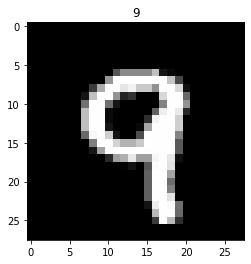

In [8]:
import matplotlib.pyplot as plt
import random as r
index = r.randrange(train_data.data.size()[0]) 
plt.imshow(train_data.data[index], cmap='gray')
plt.title('%i' % train_data.targets[index])
plt.show()

## Visualización de multiples imagenes

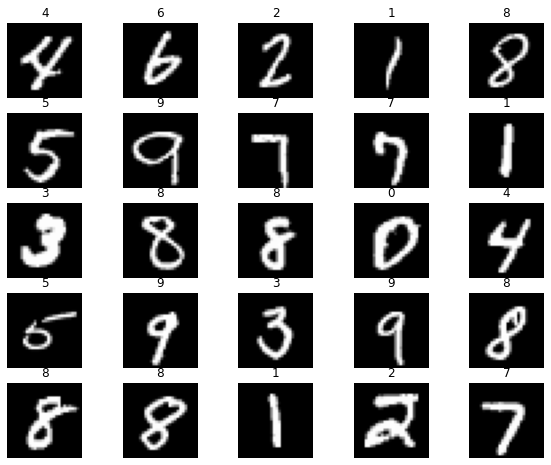

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparación de los datos

In [10]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7ff6ead53f10>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7ff6ead53f90>}

## Modelo CNN

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2)
        self.conv2 = nn.Conv2d(
                in_channels=16,
                out_channels= 32,
                kernel_size= 5,
                stride= 1,
                padding= 2) 
                
        # Capa completamente conectada con salida de 10 clases
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=(2))
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=(2))

        # Reshap, resize para flatten la salida de conv2 a (batch_size, 32 * 7 * 7)
        # x = x.view(x.size(0), -1)       
        x = torch.flatten(x,1)      
        output = self.out(x)
        return output, x    # return x for visualization


In [12]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Función de Perdida

In [13]:
# SGD
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

## Optimizador

Usando el optimizador Stochastic Gradient Descent (SGD)
<br>
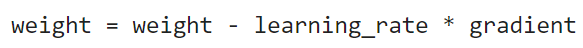

In [14]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Prueba con una matrix aleatoria

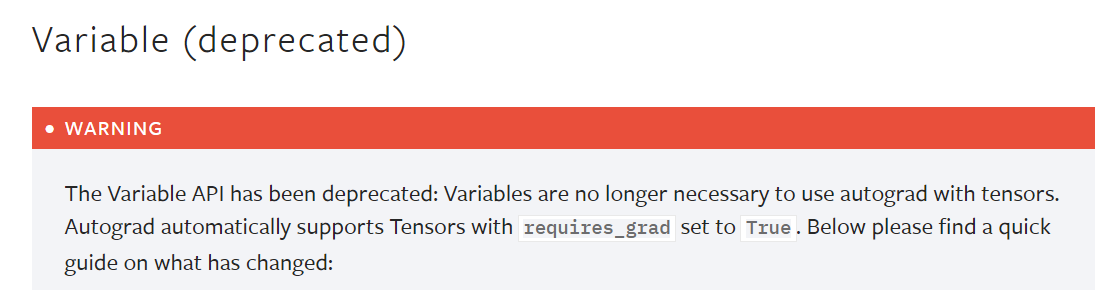

In [15]:
from torch.autograd import Variable
input = torch.randn(1, 1, 28, 28)
print(type(input))
# print(input)
print(input.shape)
input = Variable(input)
# batch size, 1 channel, image data(32,32)
print(type(input))
# print(input)
print(input.shape)

<class 'torch.Tensor'>
torch.Size([1, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([1, 1, 28, 28])


In [16]:
input = torch.randn(1, 1, 28, 28,requires_grad=True)
out = cnn(input)
print(out[0]) # 1, 10 classes

tensor([[ 0.0018, -0.2553,  0.1602, -0.1538,  0.1150,  0.0742, -0.0463,  0.2305,
          0.0737,  0.0872]], grad_fn=<AddmmBackward0>)


In [17]:
output, _none_ = cnn(input)
target = torch.randn(10)  # a dummy target
target = target.view(1, -1)
criterion_temp = nn.MSELoss()

loss_temp = criterion_temp(output, target)
print(loss_temp)

tensor(1.7418, grad_fn=<MseLossBackward0>)


In [18]:
cnn.zero_grad()     
print('conv1.bias.grad before backward')
print(cnn.conv1.bias.grad)

loss_temp.backward()

print('conv1.bias.grad after backward')
print(cnn.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0754, -0.0135, -0.0572,  0.0076,  0.0440,  0.0361,  0.0081, -0.0495,
         0.0058, -0.0661,  0.0143, -0.0191, -0.0722, -0.0466, -0.0252,  0.0919])


## Fase de entrenamiento

In [19]:
train_losses=[]
train_accu=[]

def train(num_epochs, cnn, loaders):
    print('\nEpoca : %d'%num_epochs)
    cnn.train()
    # Entrenar al modelo
    total_step = len(loaders['train'])
    
    running_loss=0
    correct=0
    total=0

    trn_corr = 0
    tst_corr = 0
    for i, (images, labels) in enumerate(loaders['train']):
            
      # Cargar los datos 
      x = images  # batch x
      y = labels  # batch y


      # --Aplicar el Modelo
      output = cnn(x)[0]               
      loss = loss_func(output, y)
            
      # --Actualizar los parametros
      # Limpiar las gradientes   
      optimizer.zero_grad()           
      # backpropagation, Calcular las gradientes 
      loss.backward()    
      # Aplicar las graditnes           
      optimizer.step()

          
            
      # --Calcular el numero de predicciones
      running_loss += loss.item()
      _, predicted = output.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(loaders['train'])
    accu=100.*correct/total
        
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
  

## Ejecutando con conjunto de datos de prueba

In [20]:
eval_losses=[]
eval_accu=[]

def test():
    # Test the model
    cnn.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)

            # --Registro Hisotiral
            loss= loss_func(test_output,labels)
            running_loss+=loss.item()

            _, predicted = test_output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss=running_loss/len(loaders['test'])
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
        # print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [21]:
epochs=5
for epoch in range(1,epochs+1): 
  train(epoch,cnn,loaders)
  test()


Epoca : 1
Train Loss: 0.208 | Accuracy: 93.470
Test Loss: 0.061 | Accuracy: 97.860

Epoca : 2
Train Loss: 0.070 | Accuracy: 97.862
Test Loss: 0.051 | Accuracy: 98.330

Epoca : 3
Train Loss: 0.061 | Accuracy: 98.093
Test Loss: 0.058 | Accuracy: 98.030

Epoca : 4
Train Loss: 0.057 | Accuracy: 98.212
Test Loss: 0.046 | Accuracy: 98.440

Epoca : 5
Train Loss: 0.056 | Accuracy: 98.288
Test Loss: 0.063 | Accuracy: 98.030


## Visualización del accuracy

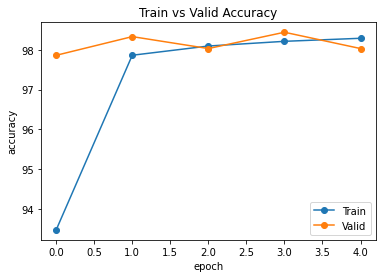

In [22]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

## Predicción con visuliación

In [23]:
# Muestreo por defecto
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:26].numpy()
actual_number

test_output, last_layer = cnn(imgs[:26])
predics = torch.max(test_output, 1)[1].data.numpy().squeeze()

# print(f'Prediction number: {pred_y}')
# print(f'Actual number: {actual_number}')

In [24]:
sample = next(iter(loaders['test']))
imgs_sample, lbls = sample

In [26]:
# Random
import random
imgs = []
actual_number = []
for i in range(0,26):
  index_r = (random.randint(0,imgs_sample.size()[0]))
  imgs.append(imgs_sample[index_r])

  actual_number.append(lbls[index_r].item())

imgs=torch.stack(imgs)
# imgs_random

test_output, last_layer = cnn(imgs)
predics = torch.max(test_output, 1)[1].data.numpy().squeeze()


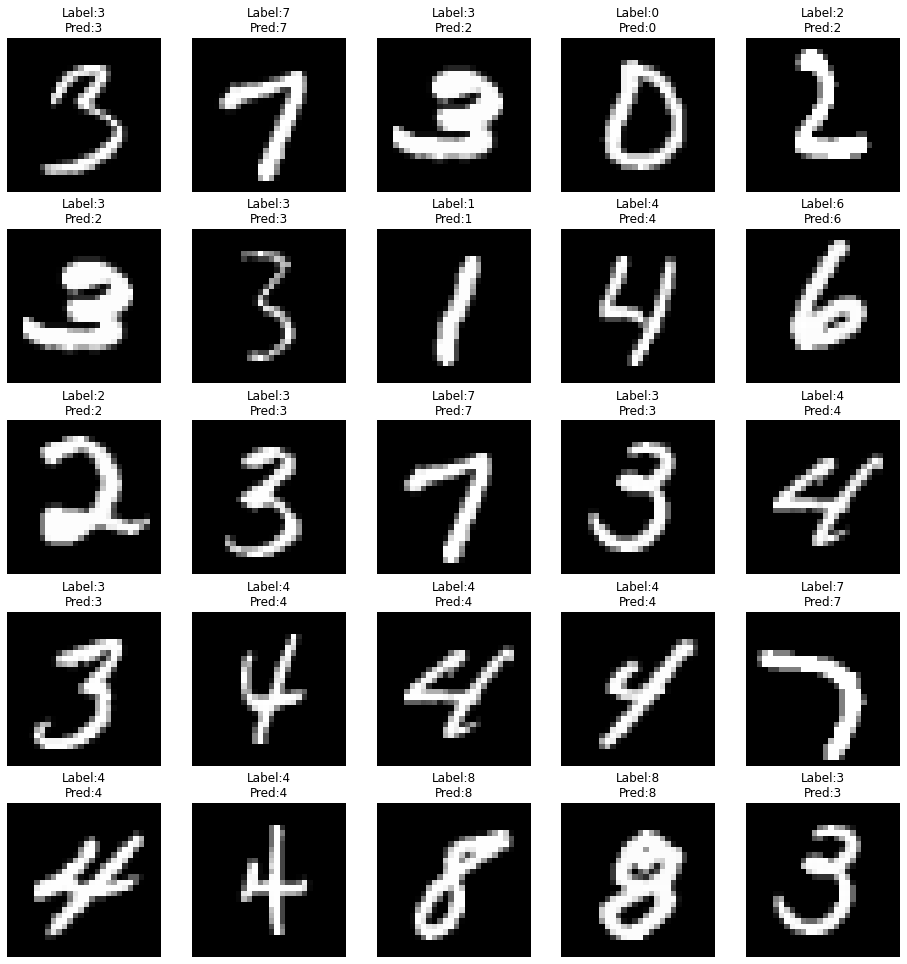

In [27]:
figure = plt.figure(figsize=(16, 17))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)

    title = "Label:"+str(actual_number[i]) + "\n"+ "Pred:"+str(predics[i])
    plt.title(title)
    plt.axis("off")
    plt.imshow(imgs[i].squeeze(), cmap="gray")
plt.show()